# Implementing new CVs via subclassing

In this tutorial we illustrate how to implement a new CV starting from one of the existing one. This reflects the situation when one wants to implement a variation of a CV by adding, for instance, a term in the loss function. 

We will consider the specific case of EncoderMap, which is a method which combines an autoencoder, optimized with the reconstruction loss, with the sketch-map loss regularizing the latent space.

## Setup

In [1]:
import mlcolvar
import torch
from torch import nn
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

## Implementing EncoderMap CV

### Sketch-map loss function

Sketch-map is a multidimensional scaling-like algorithm that aims to preserve the structural similarity, i.e. to reproduce in low-dimensional space the pairwise distances between points in the high-dimensional space
$$
\ell_{SketchMap}(\mathbf{x},\mathbf{s}) =\mathbb{E} \left[ \left(\sigma(||\textbf{x}_i-\textbf{x}_j||) - \sigma(||\textbf{s}_i-\textbf{s}_j||)\right)^2 \right]
$$
where the expectation value is over all possible pairwise distances between inputs $i$ and $j$. The pairwise distances are first transformed into sigmoid functions $\sigma$, with parameters $(x_0, a, b)$ chosen in order to focus on intermediate distances:
$$    \sigma_{x_0, a, b}(x) = 1 -\left[1+ ( 2^{a/b}-1) \left(\frac{x}{x_0}\right) ^a \right]^{-b/a}$$

We first create a new `SketchMapLoss` class, which in the costructror takes the dictionaries containing the sigmoid parameters (both high and low dimensional space). The forward method computes the the cost function, first computing the pairwise distances and evaluating the equation above.

In [2]:
def sigmoid(x,sigma,a,b):
    return 1 - (1+(2**(a/b) -1)*( x/sigma)) **(-b/a)

class SketchMapLoss(torch.nn.Module):
    """Sketch-map loss function"""

    def __init__(self, high_dim_params = None, low_dim_params = None, **kwargs) -> None:
        """Constructor.

        Parameters
        ----------
        high_dim_params : dict, optional
            parameters for sigmoid acting on high-dim data, by default dict(sigma=0.75, a=12, b=6)
        low_dim_params : dict, optional
            parameters for sigmoid acting on low-dim data,  by default dict(sigma=1, a=2, b=6)
        """
        super().__init__(**kwargs)
    
        # Parameters for sigmoid functions (default values)
        self.high_dim_params = high_dim_params if high_dim_params is not None else dict(sigma=0.75, a=12, b=6)
        self.low_dim_params = low_dim_params if low_dim_params is not None else dict(sigma=1, a=2, b=6)

    def forward(self, X : torch.Tensor , s : torch.Tensor) -> torch.Tensor:
        """Compute

        Parameters
        ----------
        X : torch.Tensor
            high-dim points
        s : torch.Tensor
            low-dim points

        Returns
        -------
        torch.Tensor
            scalar loss 
        """

        # compute pairwise distances
        X_ij = torch.cdist(X,X)
        s_ij = torch.cdist(s,s)
        n_dist = (X.shape[0]-1)**2

        # compute sketch-map cost
        loss = 1/n_dist * torch.sum( ( sigmoid(X_ij, **self.high_dim_params ) - sigmoid(s_ij, **self.low_dim_params ) )**2 ) 

        return loss

### Defining the CV

We can now define an `EncoderMap` CV by subclassing the `AutoEncoderCV` class. This allows us to retain all of the methods already implemented for the autoencoder and just add the sketch-map loss. 

**\_\_init__**

The constructor, besides the usual arguments of `AutoEncoderCV` which are repeated for convenience, takes the following arguments:
- `losses_ratio` which set the relative weighting of the sketch-map/reconstruction loss.
- `high_dim_params` and `low_dim_params` which set the parameters of the sigmoid functions in the high/low dimensional spaces

An instance of the SketchMapLoss is saved into `sketchmap_fn`, which allows us to modify the sigmoid default parameters after initialization.

**training_step**

Here we first compute a complete pass of the network (encoder+decoder) to evaluate the reconstruction loss. This is done by calling the method of the `super` class. 
Then we evaluate the sketch map loss based on the inputs as well as the latent space and sum them. 

In [3]:
from mlcolvar.cvs import AutoEncoderCV

class EncoderMap(AutoEncoderCV):
    
    def __init__(self, encoder_layers: list, decoder_layers: list = None, 
                       losses_ratio : float = 100, 
                       high_dim_params: dict = None,
                       low_dim_params: dict = None,
                       options: dict = None, **kwargs):
                       
        """EncoderMap CV built from an AutoEncoderCV, optimized with both reconstruction and
        sketch-map losses.

        Parameters
        ----------
        losses_ratio : float, optional
            ratio of sketch-map vs MSE loss, by default 100
        high_dim_params : dict, optional
            dictionary of sigmoid parameters (input space)
        low_dim_params: dict, optional
            dictionary of sigmoid parameters (latent space)

        See also
        --------
        mlcolvar.cvs.AutoEncoderCV

        """
        super().__init__(encoder_layers=encoder_layers, decoder_layers=decoder_layers, options=options, **kwargs)

        # LOSS FUNCTIONS
        # Note: Autoencoder has MSE as primary loss, i.e., self.loss_fn = MSELoss()
        # here we add also the sketch-map loss (params can be set by changing its members)
        self.sketchmap_fn = SketchMapLoss()

        # PARAMETERS
        self.losses_ratio = losses_ratio

    def training_step(self, train_batch, batch_idx):
        """Training step"""
        # 1) this computes reconstruction loss
        rec_loss = super().training_step(train_batch, batch_idx)

        # 2) compute sketch-map loss
        X = train_batch['data']
        s = self.forward_cv(X)
        sketchmap_loss = self.sketchmap_fn(X,s)

        # 3) sum them to get total loss
        loss = rec_loss + self.losses_ratio * sketchmap_loss

        # log metrics
        name = 'train' if self.training else 'valid'       
        self.log(f'{name}_sketchmap_loss', loss, on_epoch=True)
        self.log(f'{name}_total_loss', loss, on_epoch=True)
        return loss 

That's it! Now we can simply use it

## Test the new CV

### Load modified Muller-Brown 3 states data

In [4]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

dataset = create_dataset_from_files("data/muller-brown-3states/unbiased/high-temp/COLVAR",filter_args=dict(regex='p.x|p.y') )
datamodule = DictModule(dataset)

Class 0 dataframe shape:  (5001, 12)

 - Loaded dataframe (5001, 12): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker']
 - Descriptors (5001, 2): ['p.x', 'p.y']


To choose the value for sigma we can compute an histogram of the distances, here we use 0.2. 
Please refer to the sketch-map/encodermap literature for how to select the parameters.

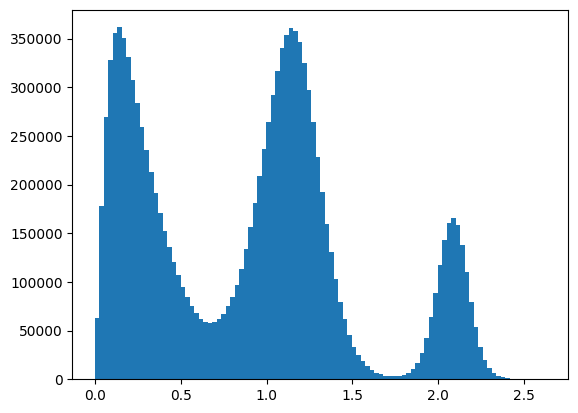

In [5]:
X = dataset['data']
X_ij = torch.cdist(X,X)

ind = torch.triu_indices(X_ij.shape[0], X_ij.shape[1], offset=1)
dist = X_ij[ind[0],ind[1]].numpy()

plt.hist(dist,bins=100)
plt.show()

Define the CV and optimize it

In [7]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define model and set sketch-map parameters
nn_kwargs = dict(activation='shifted_softplus')
options = {'encoder': nn_kwargs, 'decoder':nn_kwargs }

model = EncoderMap( encoder_layers=[2,10,10,2],
                    losses_ratio = 100,
                    high_dim_params = dict(sigma=0.2, a=6, b=6),
                    low_dim_params = dict(sigma=1.00, a=3, b=6),
                    options=options ) 

# define callbacks and trainer
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", mode='min', min_delta=1e-3, patience=20)
trainer = lightning.Trainer(callbacks=[metrics,early_stopping],
                            max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch2.0/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch2.0/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `

/home/lbonati@iit.local/software/anaconda3/envs/pytorch2.0/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 214: 100%|██████████| 1/1 [00:00<00:00, 44.38it/s, v_num=48] 


We can also monitor the learning curves

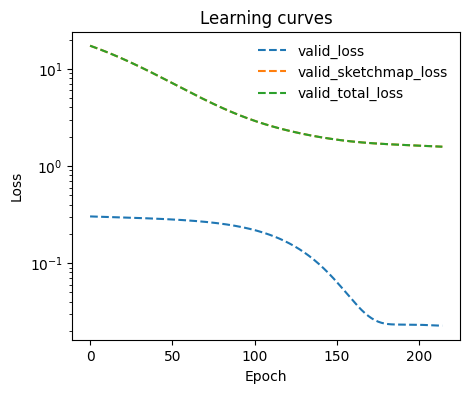

In [8]:
model.eval()

keys = [k for k in metrics.metrics.keys() if 'valid' in k]

ax = plot_metrics(metrics.metrics, 
                  keys=keys,
                  linestyles=['--' for _ in keys],
                  yscale='log')

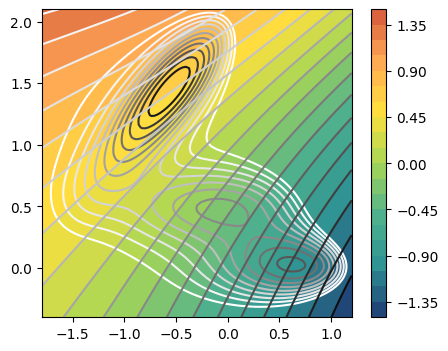

In [10]:
n_components = 1

fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=25, ax=ax)
    plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)